In [23]:
import os
import json
import tqdm
import yaml

import torch
import numpy as np
import matplotlib.pyplot as plt

from omegaconf import OmegaConf
from pathlib import Path
from tqdm.auto import tqdm
os.makedirs('./learning_curves', exist_ok=True)

In [24]:
%%bash
fusermount -uz /mnt/work/deep_al
sshfs cluster.ies:/mnt/work/deep_al/ /mnt/work/deep_al

In [25]:
def load_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def load_results(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
    exp_json = path / 'results.json'
    results = load_json(exp_json)
    return results

def load_args(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
    exp_cfg = path / '.hydra' / 'config.yaml'
    cfg =  OmegaConf.load(exp_cfg)
    return cfg

def load_checkpoint(path, final=True):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
    if final:
        exp_pth = path / 'model_final.pth'
    else:
        exp_pth = path / 'checkpoint.pth'
    checkpoint = torch.load(exp_pth)
    return checkpoint

def get_experiments(result_path, glob_pattern, train_results=False):
    # Aggregate results over multiple glob pattern such as seeds
    experiments = []
    for exp_path in result_path.glob(glob_pattern):
        d = load_results(exp_path)
        experiments.append(d)
    assert len(experiments) != 0, f'No experiments found for {result_path}.'
    return experiments

path = "/mnt/work/deep_al/results/al_baselines/CIFAR10/resnet18/random/budget_10000"
exp_results = get_experiments(Path(path), 'seed1')
# metrics = get_metric_values(exp_results)
print(exp_results[0].keys())
# print(len(exp_results[0]['results']['train_history']))
# print(exp_results[0]['results']['test_stats'].keys())

dict_keys(['cycle0', 'cycle1', 'cycle2', 'cycle3', 'cycle4', 'cycle5', 'cycle6', 'cycle7', 'cycle8', 'cycle9'])


In [29]:
budget = 1_000
experiments = {
    "Random": f"/mnt/work/deep_al/results/al_baselines/CIFAR10/resnet18/random/budget_{budget}",
    "Entropy": f"/mnt/work/deep_al/results/al_baselines/CIFAR10/resnet18/entropy/budget_{budget}",
}

learning_curves = {}
for exp_name, path in experiments.items():
    seed_results = get_experiments(Path(path), glob_pattern='seed*')

    seed_accuracies = []
    seed_num_labeled = []
    for results in seed_results:
        seed_accuracies.append([val['test_stats']['accuracy'] for key, val in results.items()])
        seed_num_labeled.append([val['n_labeled_samples'] for key, val in results.items()])
    metrics = {
        'acc': np.mean(seed_accuracies, axis=0), 
        'acc_std': np.std(seed_accuracies, axis=0), 
        'num_labeled': np.mean(seed_num_labeled, axis=0)
    }
    learning_curves[exp_name] = metrics

In [30]:
from omegaconf import OmegaConf
print(OmegaConf.to_yaml(load_args(Path(experiments['Random']) / 'seed1')))

al_cycle:
  n_init: 100
  acq_size: 100
  n_acq: 9
  cold_start: true
random_seed: 1
dataset_path: /mnt/work/dhuseljic/datasets
val_interval: 25
output_dir: /mnt/work/deep_al/results/al_baselines/CIFAR10/resnet18/random/budget_1000/seed1/
model:
  name: resnet18_deterministic
  num_epochs: 200
  train_batch_size: 64
  predict_batch_size: 256
  optimizer:
    lr: 0.001
    weight_decay: 0.05
    momentum: 0.9
dataset:
  name: CIFAR10
al_strategy:
  name: random



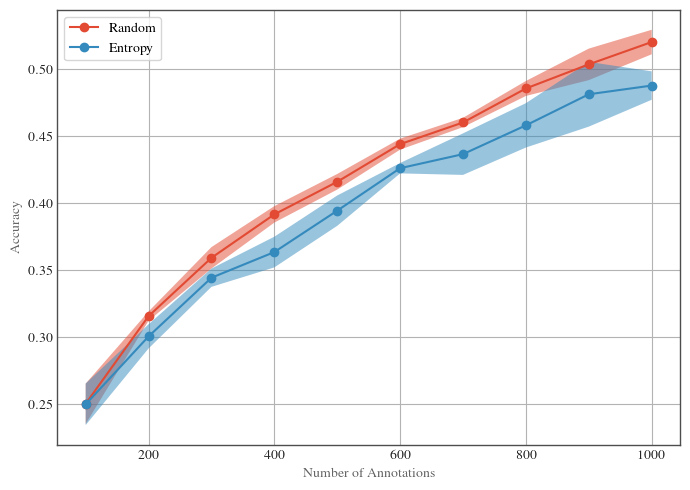

In [32]:
plt.figure(figsize=(7, 5))
for exp_name, metrics in learning_curves.items():
    plt.plot(metrics['num_labeled'], metrics['acc'], '-o', label=exp_name)
    plt.fill_between(metrics['num_labeled'], metrics['acc'] - metrics['acc_std'], metrics['acc'] + metrics['acc_std'], alpha=.5)
plt.xlabel('Number of Annotations')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig(f'learning_curves/budget{budget}.png')
plt.show()